In [1]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.utils import to_categorical
from wavhandler import *
from utils_train import train_test_val_split
import math
from utils_train import train_generator, valid_generator

# data = Dataset('Wingbeats')
# data.read(data="all", setting='read', loadmat=False, labels='nr')


data1 = Dataset('Leafminers')
data1.read(data=data1.target_classes[0], setting='read', loadmat=False, labels='nr')

data2 = Dataset('LG')
data2.read(data=data2.target_classes[0], setting='read', loadmat=False, labels='nr')

data3 = Dataset('LG')
data3.read(data=data3.target_classes[1], setting='read', loadmat=False, labels='nr')

data4 = Dataset('Pcfruit')
data4.read(data=data4.target_classes[1], setting='read', loadmat=False, labels='nr')

# data1.clean(plot=False)
# data2.clean(plot=False)
# data3.clean(plot=False)
# data4.clean(plot=False)

data = pd.DataFrame()
data['filenames'] = pd.concat([data1.filenames, data2.filenames, data3.filenames, data4.filenames], axis=0).reset_index(drop=True)
data['y'] = data.filenames.apply(lambda x: x.split('/')[6])

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['y'] = le.fit_transform(data['y'])

####
X,y = data.filenames.tolist(), data.y.tolist()
#values.reshape(-1,1)

model_name='raw_noundersampling_' 
setting='raw'
top_weights_path = TEMP_DATADIR + str(model_name) + '.h5'
targets = len(np.unique(y))
batch_size = 32

if False:#undersampling:
    from imblearn.under_sampling import RandomUnderSampler
    ros = RandomUnderSampler(random_state=0)
    ros.fit(X,y)
    X, y = ros.fit_resample(X,y)
    X = pd.Series(X.ravel()).tolist()
    y = pd.Series(y.ravel()).tolist()
    print('After undersampling: \n{}\n'.format(pd.DataFrame(y).iloc[:,0].value_counts()))
else:
    print('Class balance: \n{}\n'.format(pd.DataFrame(y).iloc[:,0].value_counts()))


X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(X,y, random_state=0)

Using TensorFlow backend.


Data: Chicorii.
Read 1451 filenames in 0.02 seconds.
Data: LG_drosophila_10_09.
Read 5536 filenames in 0.13 seconds.
Data: LG_zapr_26_09.
Read 7210 filenames in 0.13 seconds.
Data: D. suzukii.
Read 6423 filenames in 0.06 seconds.
Class balance: 
3    7210
1    6423
2    5536
0    1451
Name: 0, dtype: int64



In [4]:
from keras.models import model_from_yaml
yaml_file = open('./temp_data/raw_noundersampling__raw_final.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)

# load weights into new model
loaded_model.load_weights("./temp_data/raw_noundersampling_.h5")
print("Loaded model from disk")

loaded_model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


/home/kalfasyan/miniconda3/envs/wingbeats/lib/python3.7/site-packages/keras/engine/saving.py:473: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(yaml_string)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk


In [5]:
loss, acc = loaded_model.evaluate_generator(valid_generator(X_test, 
                                                    y_test, 
                                                    batch_size=batch_size, 
                                                    setting=setting, 
                                                    target_names=data['y'].unique().tolist()),
        steps = int(math.ceil(float(len(X_test)) / float(batch_size))))

In [6]:
y_pred = loaded_model.predict_generator(valid_generator(X_test, 
                                                    y_test, 
                                                    batch_size=batch_size, 
                                                    setting=setting, 
                                                    target_names=data['y'].unique().tolist()),
        steps = int(math.ceil(float(len(X_test)) / float(batch_size))))

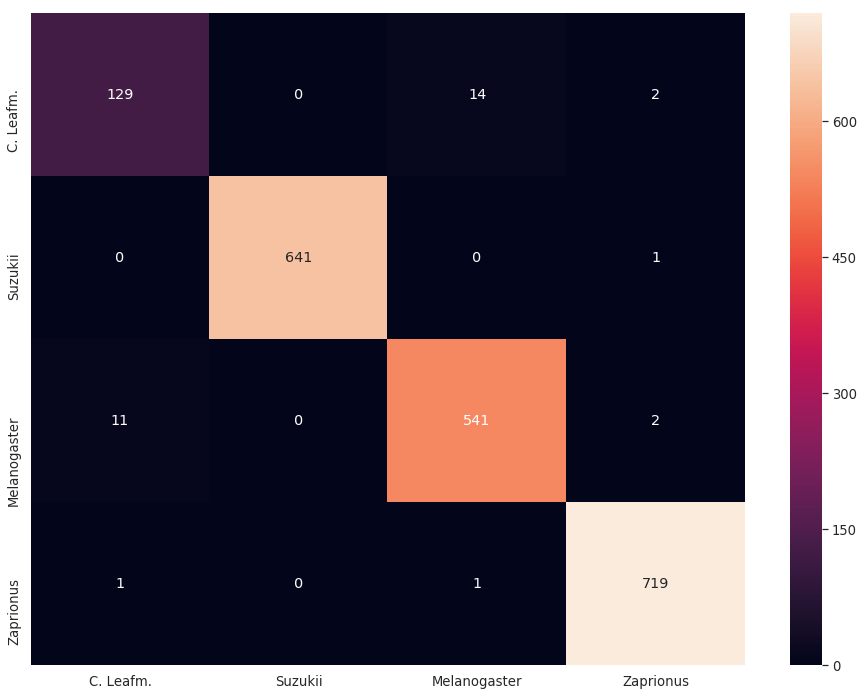

In [7]:
from sklearn.metrics import confusion_matrix
x = confusion_matrix(np.array(y_test), np.argmax(y_pred, axis=1))
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
sns.set(font_scale=1.2)
ticks = ['C. Leafm.', 'Suzukii','Melanogaster','Zaprionus']
sns.heatmap(x, annot=True, fmt='.0f', xticklabels=ticks, yticklabels=ticks)

In [44]:
suz = 1
zapr = 3
mel = 2
chic = 0

In [65]:
sns.heatmap?

Signature:
sns.heatmap(
    data,
    vmin=None,
    vmax=None,
    cmap=None,
    center=None,
    robust=False,
    annot=None,
    fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=False,
    xticklabels='auto',
    yticklabels='auto',
    mask=None,
    ax=None,
    **kwargs,
)
Docstring:
Plot rectangular data as a color-encoded matrix.

This is an Axes-level function and will draw the heatmap into the
currently-active Axes if none is provided to the ``ax`` argument.  Part of
this Axes space will be taken and used to plot a colormap, unless ``cbar``
is False or a separate Axes is provided to ``cbar_ax``.

Parameters
----------
data : rectangular dataset
    2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
    is provided, the index/column information will be used to label the
    columns and rows.
vmin, vmax : floats, optional
    Values to anchor the colormap, otherwise they a